In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
import scipy.stats as spstat
import time
from conquer.linear_model import high_dim

def cov_generate(std, corr=0.5):
    p = len(std)
    R = np.zeros(shape=[p,p])
    for j in range(p-1):
        R[j, j+1:] = np.array(range(1, len(R[j,j+1:])+1))
    R += R.T
    return np.outer(std, std)*(corr*np.ones(shape=[p,p]))**R

from joblib import Parallel, delayed
import multiprocessing
multiprocessing.cpu_count()

6

### Model selection and post-selection inference via bootstrap for high-dimensional quantile regression

In [2]:
n = 256
p = 1028
s = 8
tau = 0.8
 
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
beta = np.zeros(p)
beta[:21] = [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, -1, 0, 0, -1, 0, 0, -1]
true_set = np.where(beta!=0)[0]
print('true model:', true_set+1)

def boot_sim(m, itcp=True, parallel=False, ncore=0):
    rgt.seed(m)
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = 4 + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    sqr = high_dim(X, Y, intercept=itcp)
    lambda_sim = 0.75*np.quantile(sqr.self_tuning(tau), 0.9)

    boot_model = sqr.boot_inference(tau=tau, Lambda=lambda_sim, weight="Multinomial",
                                    parallel=parallel, ncore=ncore)
    
    per_ci = boot_model['percentile_ci']
    piv_ci = boot_model['pivotal_ci']
    norm_ci = boot_model['normal_ci']
    
    est_set = np.where(boot_model['boot_beta'][itcp:,0]!=0)[0]
    mb_set = boot_model['majority_vote']
    tp =  len(np.intersect1d(true_set, est_set))
    fp  = len(np.setdiff1d(est_set, true_set))
    mb_tp = len(np.intersect1d(true_set, mb_set))
    mb_fp = len(np.setdiff1d(mb_set, true_set))
    
    ci_cover = np.c_[(beta>=per_ci[1:,0])*(beta<=per_ci[1:,1]), 
                     (beta>=piv_ci[1:,0])*(beta<=piv_ci[1:,1]),
                     (beta>=norm_ci[1:,0])*(beta<=norm_ci[1:,1])]
    ci_width = np.c_[per_ci[1:,1] - per_ci[1:,0],
                     piv_ci[1:,1] - piv_ci[1:,0],
                     norm_ci[1:,1] - norm_ci[1:,0]]            
    return {'tp': tp, 'fp': fp, 'mb_tp': mb_tp, 'mb_fp': mb_fp, 
            'ci_cover': ci_cover, 'ci_width': ci_width}

true model: [ 1  3  6  9 12 15 18 21]


In [3]:
ci_cover, ci_width = np.zeros([p, 3]), np.zeros([p, 3])
M = 200
# true and false positives
tp, fp = np.zeros(M), np.zeros(M)
mb_tp, mb_fp = np.zeros(M), np.zeros(M)

runtime = 0
for m in range(M):
    tic = time.time()  
    out = boot_sim(m, parallel=True, ncore=6)
    runtime += time.time() - tic
    
    tp[m], fp[m], mb_tp[m], mb_fp[m] = out['tp'], out['fp'], out['mb_tp'], out['mb_fp']
    ci_cover += out['ci_cover']
    ci_width += out['ci_width']
      
    if (m+1)%10 == 0: print(m+1,'repetitions')

10 repetitions
20 repetitions
30 repetitions
40 repetitions
50 repetitions
60 repetitions
70 repetitions
80 repetitions
90 repetitions
100 repetitions
110 repetitions
120 repetitions
130 repetitions
140 repetitions
150 repetitions
160 repetitions
170 repetitions
180 repetitions
190 repetitions
200 repetitions


In [4]:
cover = pd.DataFrame(ci_cover/M, columns=['percentile', 'pivotal', 'normal'])
width = pd.DataFrame(ci_width/M, columns=['percentile', 'pivotal', 'normal'])

boot_out = pd.concat([width.iloc[true_set,:], cover.iloc[true_set,:]], axis=1)
boot_out.index = boot_out.index + 1
print(boot_out,
      '\ntrue model:',      true_set+1,
      '\naverage runtime:', runtime/M,
      '\ntrue positive:',   np.mean(tp), 
      '\nfalse positive:',  np.mean(fp),
      '\nVSC prob:',        np.mean((tp==8)*(fp==0)), 
      '\ntrue pos after boot:',  np.mean(mb_tp),
      '\nfalse pos after boot:', np.mean(mb_fp),
      '\nVSC prob after boot:',  np.mean((mb_tp==8)*(mb_fp==0)))
# VSC: variable selection consistency

    percentile   pivotal    normal  percentile  pivotal  normal
1     0.399088  0.399088  0.405757       0.960    0.915   0.940
3     0.424745  0.424745  0.427835       0.970    0.910   0.960
6     0.308084  0.308084  0.313147       0.975    0.925   0.975
9     0.525776  0.525776  0.533125       0.945    0.920   0.935
12    0.405016  0.405016  0.413116       0.970    0.930   0.975
15    0.406388  0.406388  0.415548       0.975    0.955   0.965
18    0.361014  0.361014  0.367652       0.975    0.920   0.970
21    0.405369  0.405369  0.412754       0.970    0.920   0.940 
true model: [ 1  3  6  9 12 15 18 21] 
average runtime: 12.561057119369506 
true positive: 8.0 
false positive: 1.31 
VSC prob: 0.27 
true pos after boot: 8.0 
false pos after boot: 0.04 
VSC prob after boot: 0.96


Text(0.5, 1.0, 'Histogram of False Positives')

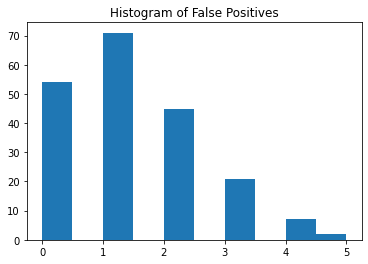

In [5]:
fig1 = plt.hist(fp)
plt.title(r'Histogram of False Positives')

Text(0.5, 1.0, 'Histogram of False Positives after Bootstrap')

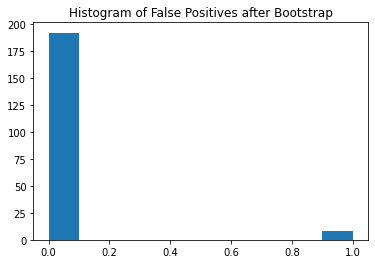

In [6]:
fig2 = plt.hist(mb_fp)
plt.title(r'Histogram of False Positives after Bootstrap')